In [14]:
import os
import sys
import seawater as sw
from scipy import interpolate as interp

sys.path.append("../scripts")
sys.path.append("../src/iw_model")
sys.path.append("../src/iw_inverse")
sys.path.append("../src/misc")

from iw_invert import InternalWaveInversion
from iw_plots import *
from extract import *

In [3]:
"""
Read data and compute means
"""
path = os.path.join("..","matlab",filename)
table = read_table(path)

#Define a slice of data
DSL = slice(15,80) # depth slice
sl = (slice(0,2000),DSL,slice(0,-1),slice(0,-1))

#Get state variables
N2 = extract_node(table,'N2')[sl]
T  = extract_node(table,'T')[sl]
S  = extract_node(table,'S')[sl]
W  = extract_node(table,'W')[sl]*100
Z  = extract_node(table,'z').flatten()[sl[1]]

#Compute Density from state variables
RP = sw.eos80.dens(S,T,2000)

TIME   = extract_node(table,'time').flatten()[sl[0]]
DEPTH  = extract_node(table,'z').flatten()[sl[1]]

#Start time at zero
t0 = matlab2datetime(TIME[1]).timestamp()
TIME = [round(matlab2datetime(T).timestamp()-t0) for T in TIME]
X = 1e3*np.arange(0,22,2)
Y = 1e3*np.arange(0,22,2)

#Form a coordinate matrix
AX = np.array(list(itertools.product(*[TIME,DEPTH,X,Y])),dtype=[('t',float),('z',float),('x',float),('y',float)])
AX = AX.reshape(T.shape)

In [4]:
"""
Compute means
"""
#Compute the mean stratification
N2_mean = np.mean(N2,axis=(0,2,3))
T_mean  = np.mean(T,axis=(0,2,3))
S_mean  = np.mean(S,axis=(0,2,3))
R_mean  = sw.eos80.dens(S_mean,T_mean,2000)
#R_mean  = sw.eos80.pden(S_mean[DSL],T_mean[DSL],Z[DSL],pr=2000)


#Create a function that is depth as a function of the mean density
zofr = interp.InterpolatedUnivariateSpline(R_mean,Z)
DZ   = AX['z'] - zofr(RP) 

In [5]:
"""
M2 band pass filter
"""
def bandpass_filter(center,half_width,fs,order=5):
    nyq = fs*0.5
    lo = (center-half_width/nyq)
    hi = (center+half_width/nyq)
    b, a = sig.butter(order, [lo, hi], btype='band')
    return b,a

M2  = .0805 
bw  = .02
b,a = bandpass_filter(M2,bw,1)
DZB = sig.lfilter(b,a,DZ,axis=0)
RPB = sig.lfilter(b,a,RP,axis=0)
WB = sig.lfilter(b,a,W,axis=0)



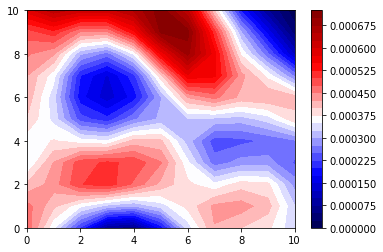

In [6]:
import matplotlib.animation as animation
from IPython.display import HTML
"""
Animation of 500 meter depth displacment
"""
fig,ax = plt.subplots()
p = ax.contourf(DZB[0,24,:,:],levels=30,cmap='seismic')
fig.colorbar(p,ax=ax)

def update(frame):
    ax.contourf(DZB[frame,24,:,:],levels=30,cmap='seismic')
    return p,
    

#Compile Animation
ani = animation.FuncAnimation(fig, update,frames=np.arange(0,48,1),blit=False)

ani.save("foo.mp4")


In [7]:
Z[60]

2898.48

In [134]:
"""
Compute Inversion All Data
"""
%load_ext autoreload
%autoreload

#Interpolat N2 to a regularized grid
n2ofz = interp.InterpolatedUnivariateSpline(Z[DSL],N2_mean[DSL])
Z_even = np.linspace(Z[10],Z[60],100)
isl = (slice(0,168,7),slice(10,50,2),slice(0,11),slice(0,11))
#Subsample data set create dataframe
cube = pd.DataFrame({"dz"    : DZB[isl].flatten(),
                     "time"  : AX[isl]["t"].flatten(),
                     "z"     : AX[isl]["z"].flatten(),
                     "x"     : AX[isl]["x"].flatten(),
                     "y"     : AX[isl]["y"].flatten()
                    })

cube['date'] = pd.to_datetime(cube['time'] + t0, unit='s')

#Compute depth variance then apply it to the dataset
R = np.var(DZ[isl], axis=(0,2,3))
Zr = AX[0,isl[1],0,0]["z"]
snr = 0.9
R = np.array([ (1-snr)*r if (1-snr)*r > 4 else 4 for r in R])
RofZ = interp.interp1d(Zr,R)
cube['RINV'] = 1/RofZ(cube['z'])

#Set up parameter space
FREQS = [.0805/3600]#,2*.0805/3600]
#FREQS += list(np.arange(1/24,1/6,1/(24*2))/3600)
MODES = np.arange(0,5)
ANGLES  = np.arange(0,360,5)

#Run inversion
subdf = cube[cube['time'] < 0.5*max(cube['time'])]
iwi = InternalWaveInversion(subdf,FREQS,MODES,ANGLES,Z_even,n2ofz(Z_even),tc='dz')
iwi.ps['QINV'] =(iwi.ps['modes'] + 3)**2# np.ones(len(iwi.ps))
iwi.pinvert()



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [135]:
#Compute an estimate
%autoreload
iwi_full = InternalWaveInversion(cube,FREQS,MODES,ANGLES,Z_even,n2ofz(Z_even),tc='dz')

cube['dz_hat'] = iwi_full.H @ np.concatenate([iwi.ps['a'],iwi.ps['b']]).T
cube['err']    = cube['dz_hat'] - cube['dz']

In [126]:
np.sqrt(np.mean(cube['err'].values**2))

2.4997192512169675

In [127]:
DZ[isl].shape

(24, 20, 11, 11)

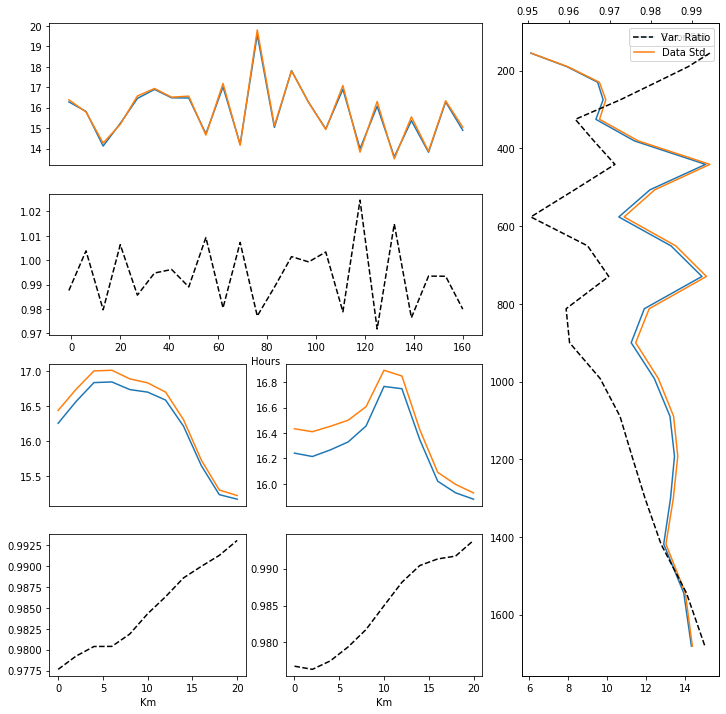

In [136]:
"""
Plot error variance across each exis
"""
%autoreload

DZH = cube['dz_hat'].values.reshape(DZ[isl].shape)
ERR = DZH-DZ[isl]
VAL = DZ[isl]

f=plt.figure()
plot_error_variance(f,ERR,VAL,AX,isl)
f.set_size_inches(12,12)

In [58]:
1e-3/iwi.ps.hwvn.unique()[1:]

array([181.78986446,  45.47482492,  19.50053564,  11.23924313,
         6.97673858])

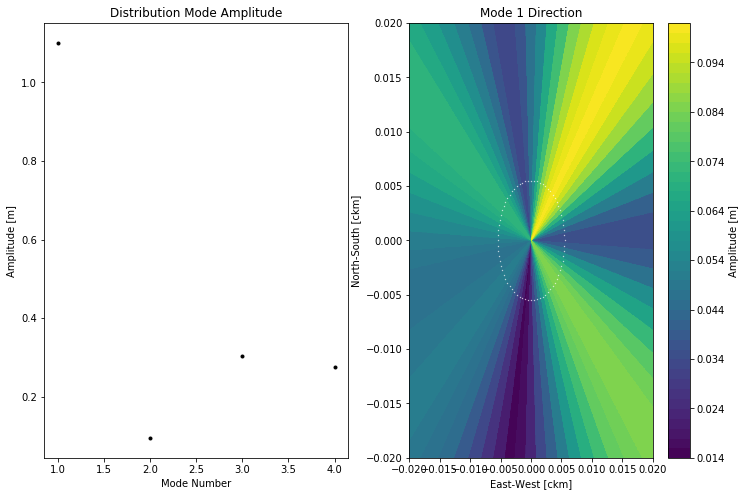

In [137]:
"""
Plotting Parameter space
"""

import scipy
def mag(a,b):
    return np.sqrt(a**2 + b**2)

## Irregular points in K-Omega space
psn = iwi.ps[ (iwi.ps['modes'] < 1) & (iwi.ps['freqs'] > 0 )]
KX = 1000*psn['hwvn']*np.cos(2*np.pi*psn['theta']/360)
KY = 1000*psn['hwvn']*np.sin(2*np.pi*psn['theta']/360)
M = mag(psn['a'].values,psn['b'].values)

r = .02
kxi = np.linspace(-r,r,1000)
kyi = np.linspace(-r,r,1000)
Kxi,Kyi = np.meshgrid(kxi,kyi)


Ai = scipy.interpolate.griddata((KX,KY),M,(Kxi,Kyi),method='nearest')
f,(ax1,ax2) =plt.subplots(1,2)
p = ax2.contourf(Kxi,Kyi,np.nan_to_num(Ai),levels=50)
ax2.scatter(KY,KX,s=0.1,c='w')
ax2.set_xlabel('East-West [ckm]')
ax2.set_ylabel('North-South [ckm]')
ax2.set_title('Mode 1 Direction')

ax1.plot( mag(iwi.ps.groupby('modes').sum()['a'][1:],iwi.ps.groupby('modes').sum()['b'][1:] ),'k.' )
ax1.set_xlabel("Mode Number")
ax1.set_ylabel("Amplitude [m]")
ax1.set_title('Distribution Mode Amplitude')
f.colorbar(p,label="Amplitude [m]")
f.set_size_inches(12,8)

../src/misc/iw_plots.py:29: RuntimeWarning: invalid value encountered in sqrt
  ax1.plot(3600*np.sqrt(iwm_obj.N2),iwm_obj.depth)


(<Figure size 432x288 with 4 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x7fe20d049810>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7fe20b998190>))

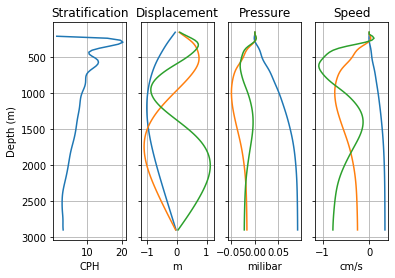

In [32]:
mode_plot(iwi.iwmodes[0])

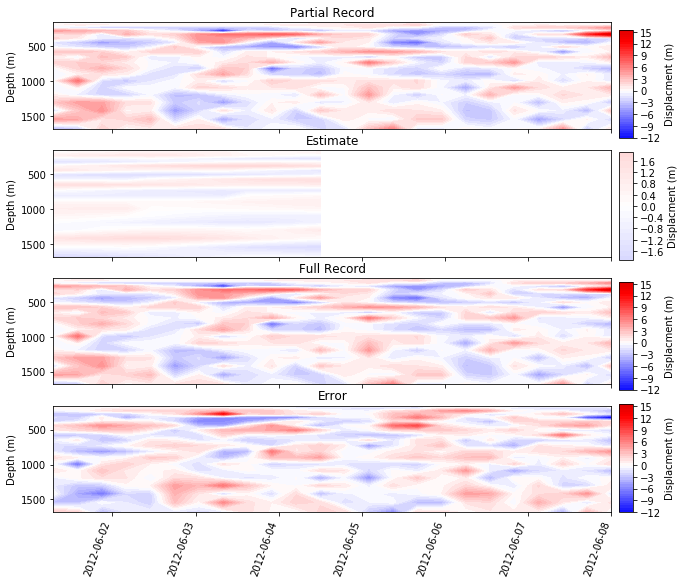

In [151]:
%autoreload
import iw_plots as iwp
"""
Plotting Forecasts
"""
line = cube[(cube["x"]==2e3) & (cube["y"]==2e3)]
f, ax = plt.subplots(4,1,sharex=True)
cnorm = (-25,0,25)
p1 = iwp.plot_dataframe_slice(line,'date','z','dz',ax[0],cnorm=(cnorm))
p2 = iwp.plot_dataframe_slice(line[line['time'] < .5*max(line['time'])],'date','z','dz_hat',ax[1],cnorm=(cnorm))
p3 = iwp.plot_dataframe_slice(line,'date','z','dz',ax[2],cnorm=(cnorm))
p4 = iwp.plot_dataframe_slice(line,'date','z','err',ax[3],cnorm=(cnorm))
ax[0].set_title('Partial Record')
ax[1].set_title('Estimate')
ax[2].set_title('Full Record')
ax[3].set_title('Error')

for a in ax:
    a.set_ylabel('Depth (m)')
f.autofmt_xdate(rotation=70)
cax1 = f.add_axes([.91, 0.72, 0.02, 0.15])
cax2 = f.add_axes([.91, 0.55, 0.02, 0.15])
cax3 = f.add_axes([.91, 0.37, 0.02, 0.15])
cax4 = f.add_axes([.91, 0.2, 0.02, 0.15])
f.colorbar(p1,cax=cax1,label="Displacment (m)")
f.colorbar(p2,cax=cax2,label="Displacment (m)")
f.colorbar(p3,cax=cax3,label="Displacment (m)")
f.colorbar(p3,cax=cax4,label="Displacment (m)")
f.set_size_inches(10,10)